# Deep Hedging of Green PPAs

In [2]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel
import numpy as np
from scipy.special import comb

import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Residual Demand Forward Model

In [3]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1]]

In [4]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=2.0, volatility=4.0)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=2.0, volatility=3.0)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany')

In [5]:
np.random.seed(42)
rnd = np.random.normal(size=model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))
paths = model.simulate(timegrid, rnd, expiries=forward_expiries, 
                                 initial_forecasts={'Onshore': [0.8],
                                                          'Offshore': [0.6]},
                                power_fwd_prices = [1.0])

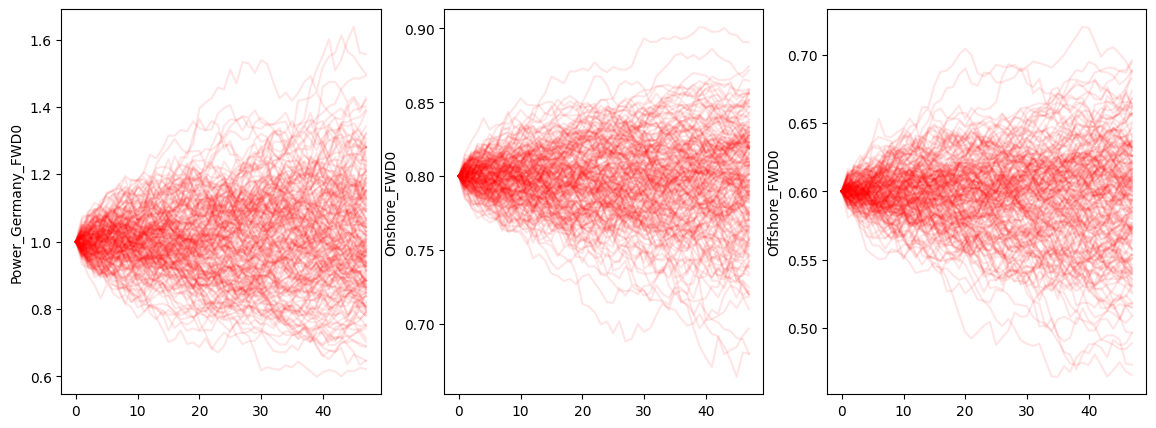

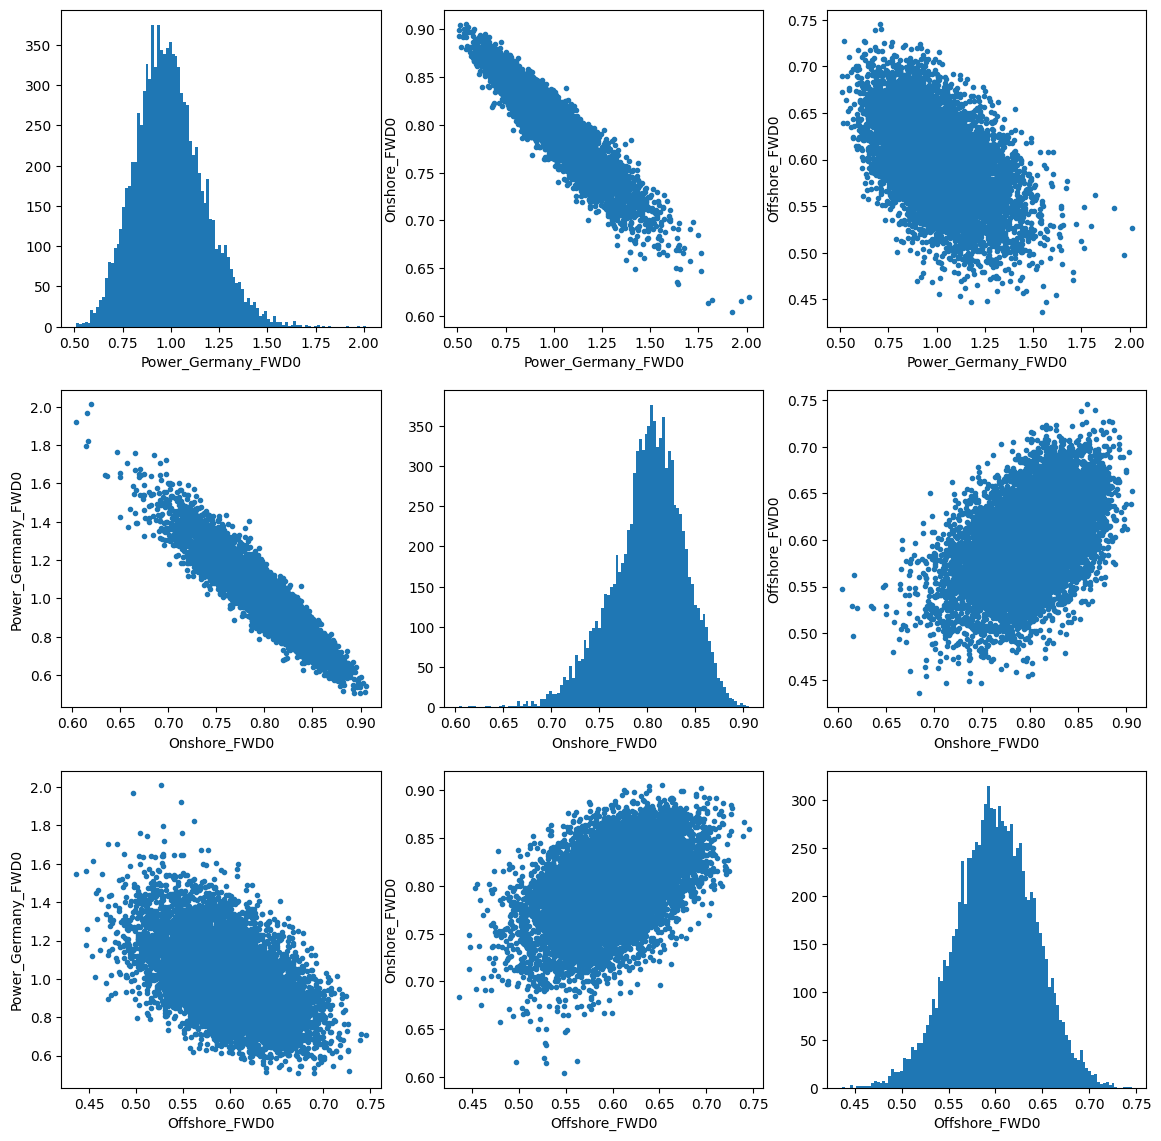

In [12]:
analysis.plot_paths(paths, None)

# Experiments

In [43]:
val_date = dt.datetime(2023,1,1)
strike = 1.0 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [44]:
repo = analysis.Repo('./experiments/')

In [45]:
repo.results.keys()

dict_keys(['val_date', 'ppa_spec', 'model', 'pricing_param', 'ppa_spec_hash', 'model_hash', 'result'])

In [47]:
pricing_results = repo.run(val_date, 
                           spec, model, 
                           initial_forecasts={'Onshore': [0.8],
                                        'Offshore': [0.6]},
                           power_fwd_prices=[1.0],
                           forecast_hours=[10, 14, 18],
                           additional_states=['Offshore'],
                           depth=3, 
                           nb_neurons=64, 
                           n_sims=100_000, 
                           regularization=0.0,
                           epochs=600, verbose=1,
                           tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                           initial_lr=5e-4,
                           decay_steps=8_000,
                           batch_size=100, decay_rate=0.8, seed=42)

C:\Users\doeltz\development\RiVaPy\sandbox\green_ppa\../..\rivapy\tools\datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


Epoch 1/600
900/900 [==============================] - 33s 15ms/step - loss: 6.9969e-05
Epoch 2/600
900/900 [==============================] - 15s 16ms/step - loss: 2.6356e-05
Epoch 3/600
900/900 [==============================] - 14s 15ms/step - loss: 2.8233e-05
Epoch 4/600
900/900 [==============================] - 14s 16ms/step - loss: 2.6124e-05
Epoch 5/600
900/900 [==============================] - 23s 25ms/step - loss: 2.4525e-05 - val_loss: 2.1817e-05
Epoch 6/600
900/900 [==============================] - 15s 16ms/step - loss: 2.4084e-05
Epoch 7/600
900/900 [==============================] - 14s 15ms/step - loss: 2.4040e-05
Epoch 8/600
900/900 [==============================] - 14s 16ms/step - loss: 2.3340e-05
Epoch 9/600
900/900 [==============================] - 15s 16ms/step - loss: 2.3740e-05
Epoch 10/600
900/900 [==============================] - 15s 16ms/step - loss: 2.2251e-05 - val_loss: 2.0454e-05
Epoch 11/600
900/900 [==============================] - 16s 17ms/step - l

900/900 [==============================] - 10s 11ms/step - loss: 1.9839e-05
Epoch 89/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9791e-05
Epoch 90/600
900/900 [==============================] - 10s 12ms/step - loss: 1.9776e-05 - val_loss: 1.9885e-05
Epoch 91/600
900/900 [==============================] - 10s 12ms/step - loss: 1.9801e-05
Epoch 92/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9710e-05
Epoch 93/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9833e-05
Epoch 94/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9662e-05
Epoch 95/600
900/900 [==============================] - 11s 12ms/step - loss: 1.9688e-05 - val_loss: 2.0627e-05
Epoch 96/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9715e-05
Epoch 97/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9680e-05
Epoch 98/600
900/900 [==============================] - 10s 11ms/step - loss:

Epoch 175/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9287e-05 - val_loss: 1.9717e-05
Epoch 176/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9275e-05
Epoch 177/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9262e-05
Epoch 178/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9259e-05
Epoch 179/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9275e-05
Epoch 180/600
900/900 [==============================] - 10s 12ms/step - loss: 1.9258e-05 - val_loss: 1.9686e-05
Epoch 181/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9269e-05
Epoch 182/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9249e-05
Epoch 183/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9268e-05
Epoch 184/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9277e-05
Epoch 185/600
900/900 [==============================]

900/900 [==============================] - 10s 12ms/step - loss: 1.9204e-05
Epoch 262/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9212e-05
Epoch 263/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9199e-05
Epoch 264/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9197e-05
Epoch 265/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9208e-05 - val_loss: 1.9674e-05
Epoch 266/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9214e-05
Epoch 267/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9183e-05
Epoch 268/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9214e-05
Epoch 269/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9207e-05
Epoch 270/600
900/900 [==============================] - 11s 12ms/step - loss: 1.9212e-05 - val_loss: 1.9681e-05
Epoch 271/600
900/900 [==============================] - 10s 11ms/st

900/900 [==============================] - 10s 11ms/step - loss: 1.9208e-05
Epoch 348/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9182e-05
Epoch 349/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9182e-05
Epoch 350/600
900/900 [==============================] - 10s 12ms/step - loss: 1.9186e-05 - val_loss: 1.9684e-05
Epoch 351/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9193e-05
Epoch 352/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9205e-05
Epoch 353/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9188e-05
Epoch 354/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9209e-05
Epoch 355/600
900/900 [==============================] - 10s 12ms/step - loss: 1.9194e-05 - val_loss: 1.9682e-05
Epoch 356/600
900/900 [==============================] - 10s 11ms/step - loss: 1.9191e-05
Epoch 357/600
900/900 [==============================] - 10s 11ms/st

KeyboardInterrupt: 

## Analysis

In [32]:
ref_results_key = '17d2b15cf14e1ecb5f73a55fdb70dd40c5699ac5'
ref_keys = ['17d2b15cf14e1ecb5f73a55fdb70dd40c5699ac5']
hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
spec = GreenPPASpecification.from_dict(repo.results[ref_results_key]['ppa_spec'])

### Model paths

C:\Users\doeltz\development\RiVaPy\sandbox\green_ppa\../..\rivapy\tools\datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


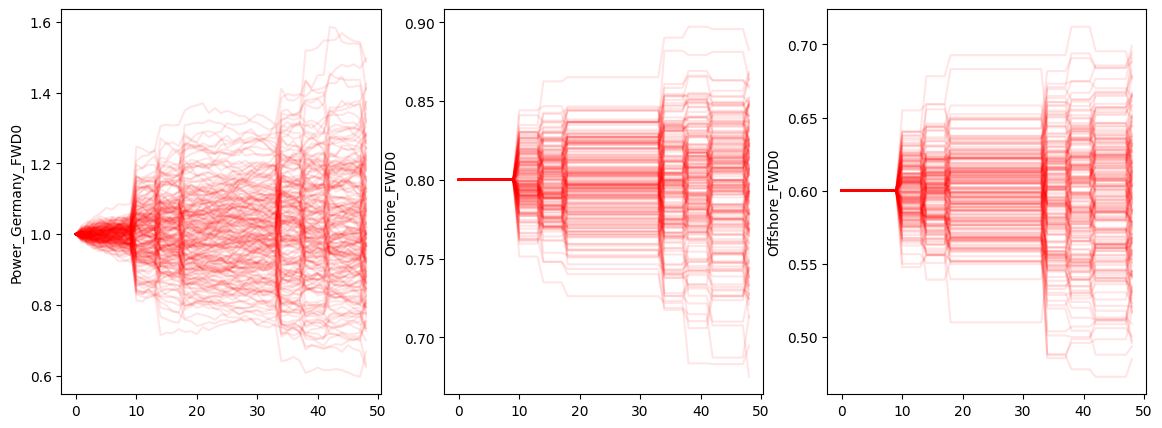

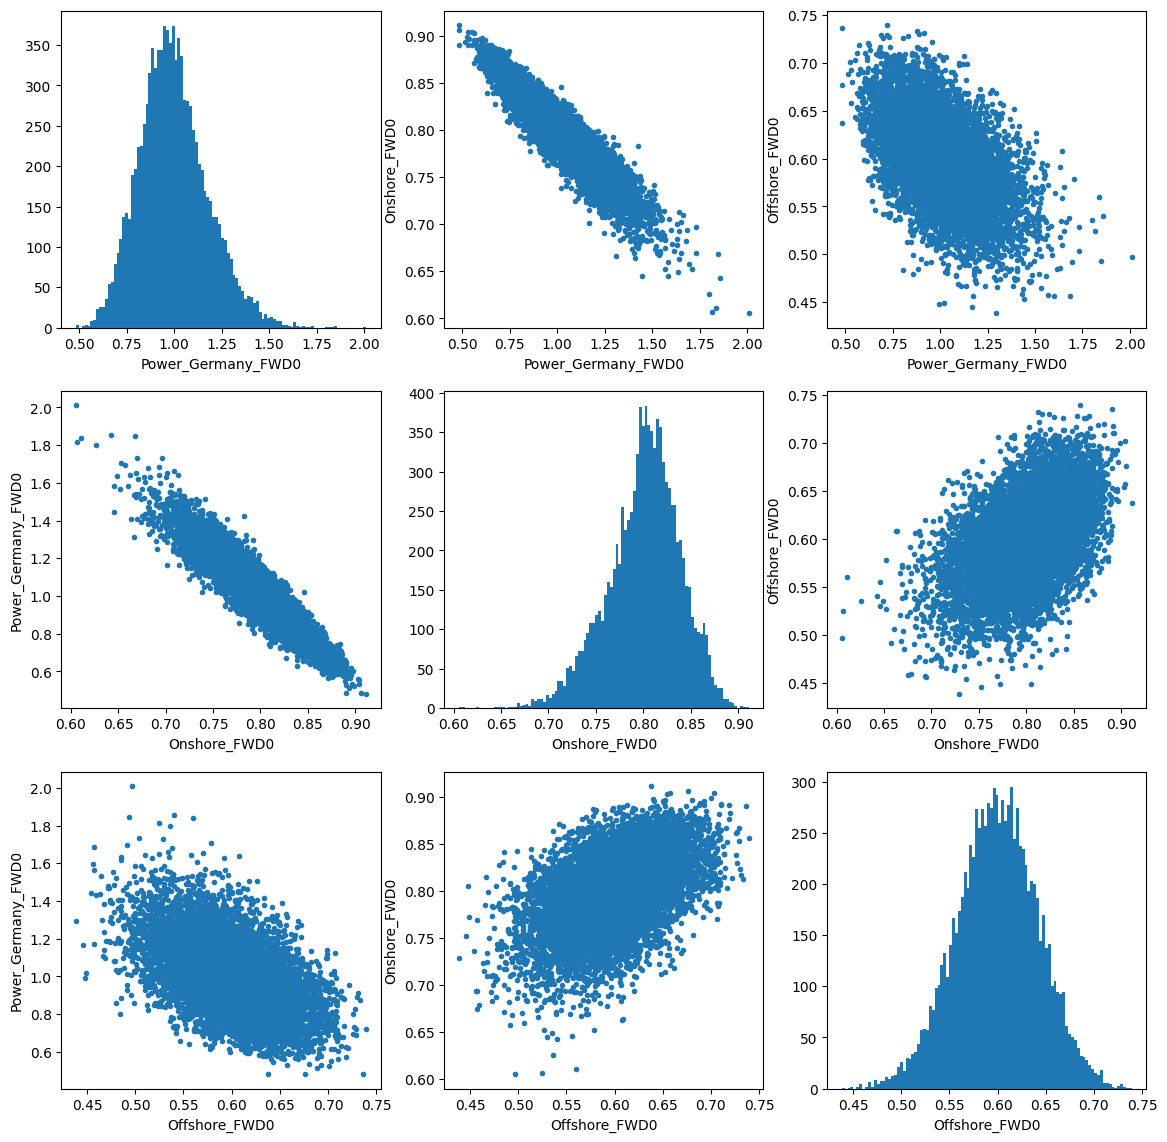

In [41]:
sim_results, forecast_points = repo.simulate_model(ref_results_key, n_sims=10_000)
analysis.plot_paths(sim_results, forecast_points)
paths = {k:sim_results.get(k, forecast_points) for k in ['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0']}

### Hedge PnL Distribution

In [35]:
def compute_pnl(hedge_model, paths, green_ppa_spec):
    power_price = paths.get('Power_Germany_FWD0', None)
    volume = paths.get(green_ppa_spec.location+'_FWD0')
    payoff = (power_price[-1,:] -green_ppa_spec.fixed_price)*(volume[-1,:])
    return hedge_model.compute_pnl(paths, payoff)

313/313 [==============================] - 8s 4ms/step


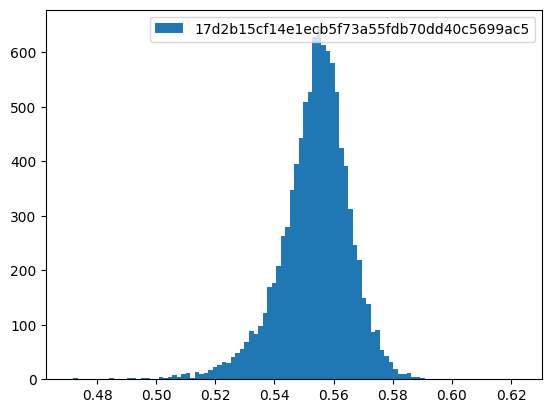

In [42]:
alpha = 1.0/len(hedge_models)
for k,v in hedge_models.items():
    pnl = compute_pnl(v, paths, spec)
    plt.hist(pnl,bins=100, label=k, alpha=alpha)
plt.legend()

## Delta Plots

313/313 [==============================] - 1s 2ms/step


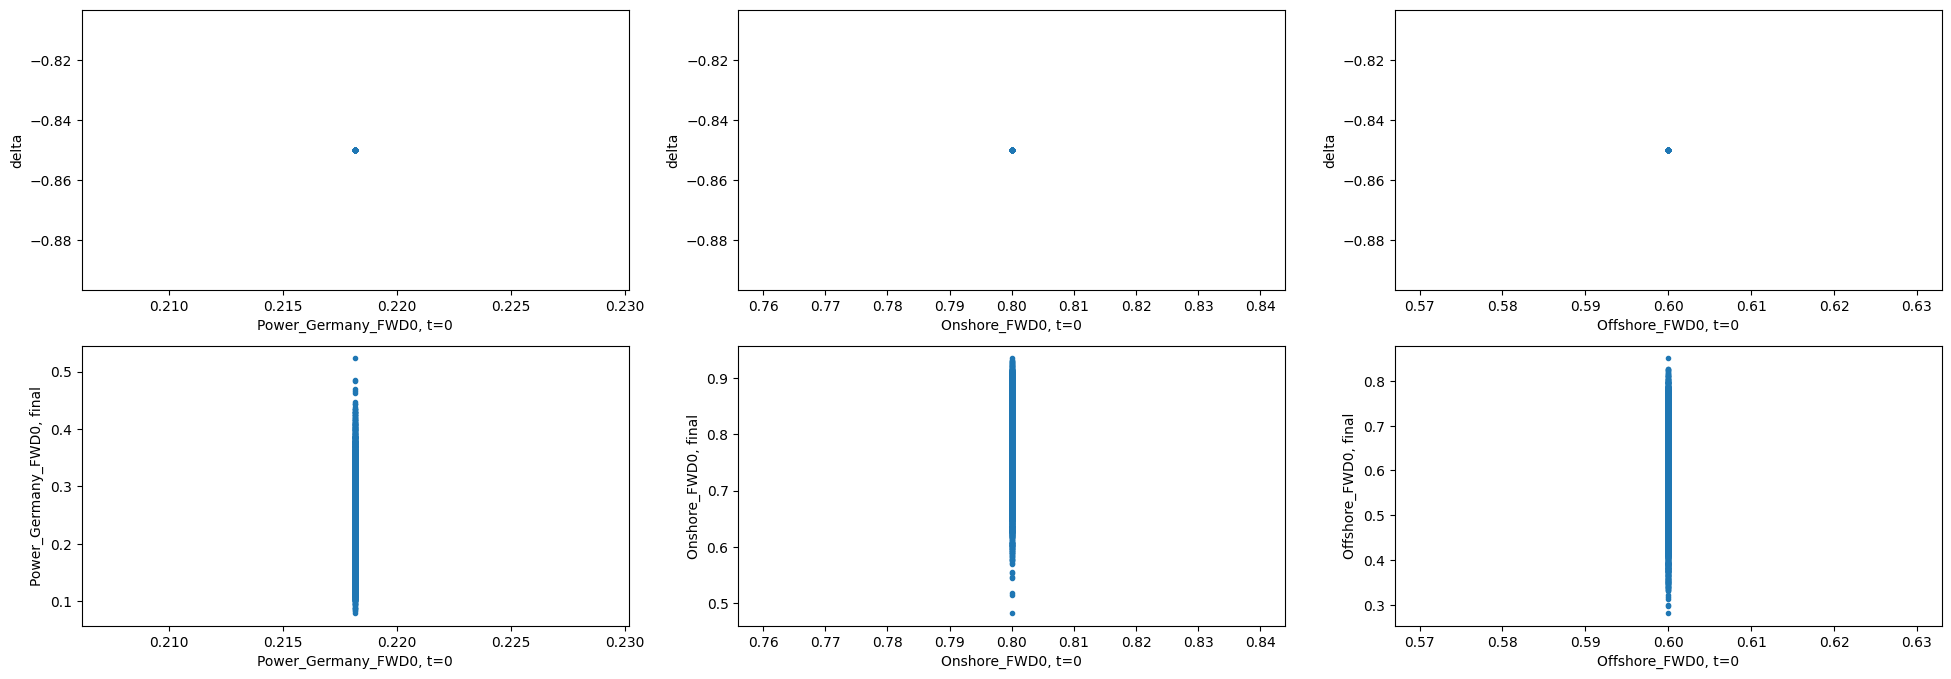

In [64]:
t = 0
n_x = 2
n_y = 3
plt.figure(figsize=(24,8))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1